In [1]:
# import packages

import pickle, pprint
import numpy as np

In [2]:
# load data

pkl_file = open('zo1_graph_timelapse_sample_v2.pkl','rb')
data1 = pickle.load(pkl_file)

# Data Visualization

In [3]:
# choose time step
# 12, 13 seems difficult
# couple of difficult ones. Need to rethink how to go about this
t = 1

Number of branches is  74
Number of nodes is  148


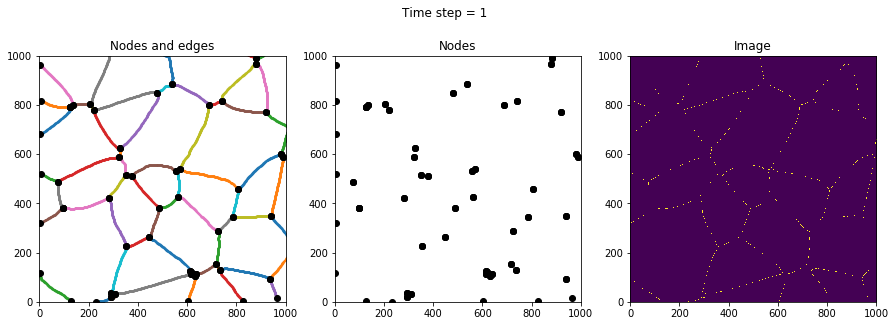

In [4]:
# plot edge, node and image data at time step t

import matplotlib
import matplotlib.pyplot as plt
from scipy import ndimage

%matplotlib inline
fig, (ax, ax2, ax3) = plt.subplots(1,3, figsize = (15,5))

# plot nodes and edges
posit = [i for i in range(len(data1[2][t]))]

for pos in posit:
    l = len(data1[2][t][pos][:])-1
    # all edges/branches
    ax.plot(data1[1][t][data1[2][t][pos][:],1], data1[1][t][data1[2][t][pos][:],0],'.', markersize = 2)
    
    # nodes (endpoints)
    ax.plot(data1[1][t][data1[2][t][pos][0],1], data1[1][t][data1[2][t][pos][0],0], 'ok')
    ax.plot(data1[1][t][data1[2][t][pos][l],1], data1[1][t][data1[2][t][pos][l],0], 'ok')

# plot nodes
for pos in posit:
    l = len(data1[2][t][pos][:])-1
    ax2.plot(data1[1][t][data1[2][t][pos][0],1], data1[1][t][data1[2][t][pos][0],0],'ok')
    ax2.plot(data1[1][t][data1[2][t][pos][l],1], data1[1][t][data1[2][t][pos][l],0],'ok')

# plot image
img = ndimage.rotate(data1[0][t] == 2, 0)
# plot the image with origin at lower left
ax3.imshow(img, origin = 'lower')

titles = ['Nodes and edges','Nodes', 'Image' ]
# axis stuff
axes = list([ax, ax2, ax3])
for j,ax in enumerate(axes):
    ax.set(xlim = [0,1000], ylim = [0,1000], aspect = 1)
    ax.set_title(titles[j])

fig.suptitle("Time step = %d" %t , fontsize=12)
print('Number of branches is ', len(posit))
print('Number of nodes is ', 2*len(posit))

# Curve fitting + Data post processing

Now we put the nodes and edges into our data structure and perform curve fits to find radius

Theres a lot of nodes stacked on top of each other. We have to group nodes together if they are really really close

What we do here is check the normalized distance of a node from all the other nodes in a list that we are constantly appending. If the distance is more than a cutoff, then we make a new node. If its less than a cutoff, then we replace that node with the closest node to it in the list. 

We only add a new branch if the node_a and node_b selected after the above process for a branch are not the same

In [5]:
# choose cutoff distance (minimum normalized distance between nodes)
# change this value if error -> impossible arc asked for, radius too small

cutoff = 7

In [6]:
# put data into node and edge classes and perform curve fitting

import sys
sys.path.insert(0, '../cell_soap/')
from cell_describe import node, edge
from fitting import fit

# posit is the list of branches
posit = [i for i in range(len(data1[2][t]))]

#list of nodes and edges to be updated
nodes, edges = [], []

for pos in posit:
    # l is the index of the last point on a branch
    l = len(data1[2][t][pos][:])-1
    
    ###################################################
    # define node class
    # check if radius is 0
    
    # node_a is the node at location 0 of a branch
    node_a = node((data1[1][t][data1[2][t][pos][0],1], data1[1][t][data1[2][t][pos][0],0]))
    
    # check if nodes list is empty
    dist = []
    for n in nodes:
        dist.append(np.linalg.norm(np.subtract(n.loc, node_a.loc)))
    
    # lets choose a cutoff pixel norm distance of 100 
    # if the distance between node_a and all nodes in list is more than

    if not dist:
        nodes.append(node_a)
    else:  
        if all(i >= cutoff for i in dist):
            nodes.append(node_a)          
        else:
            ind = dist.index(min(dist))
            node_a = nodes[ind]

    # node_b is the node at location l (last) of a branch
    node_b = node((data1[1][t][data1[2][t][pos][l],1], data1[1][t][data1[2][t][pos][l],0]))
    

    # check if nodes list is empty

    dist = []
    for n in nodes:
        dist.append(np.linalg.norm(np.subtract(n.loc, node_b.loc)))
    
    # lets choose a cutoff pixel norm distance of 100
    
    # if the distance between node_b and all nodes in list is more than 
    if not dist:
        nodes.append(node_b)
    else:  
        if all(i >= cutoff for i in dist):
            nodes.append(node_b)          
        else:
            ind = dist.index(min(dist))
            node_b = nodes[ind] 
        
    ###################################################
    # calculate radius for curve fitting
    
    # only do fit and add edge if the 2 nodes are not the same
    if node_a.loc != node_b.loc:
    
        # x and y are co-ordinates along a branch (dataset). 
        x = data1[1][t][data1[2][t][pos][:],1]
        y = data1[1][t][data1[2][t][pos][:],0]

        # we want to fit a curve to this. Use least squares fitting.
        # output is radius and x,y co-ordinates of the centre of circle
        radius, xc, yc = fit(x,y)

        # Check the direction of the curve. Do this by performing cross product 
        x1, y1, x2, y2 = x[0], y[0], x[-1], y[-1]
        v1 = [x1 - xc, y1 - yc]
        v2 = [x2 - xc, y2 - yc]
        cr = np.cross(v1, v2)
        a = 0.5*np.linalg.norm(np.subtract([x2,y2], [x1,y1])) # dist to midpoint
        ###################################################
        # define edge class
        # check if radius is 0
        if radius > 0:
            # same assertion thats in the class
            if a < radius:
                # if cross product is negative, then we want to go from node_a to node_b
                # if positive, we want to go from node_b to node_a
                if cr > 0:
                    ed = edge(node_b, node_a, radius)
                    #ed = edge(node_b, node_a, radius, xc, yc)
                else:
                    ed = edge(node_a, node_b, radius)
                    #ed = edge(node_a, node_b, radius, xc, yc)
        else:
            # if no radius, leave as None
            ed = edge(node_a, node_b, None, None, None)
        edges.append(ed)

Now we have a list of nodes and edges. Lets plot them and original data to see if the curve fit is working


Number of branches is  70
Number of nodes is  58


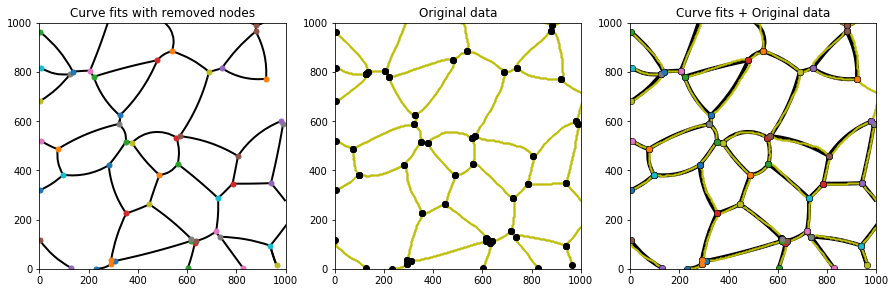

In [7]:
# check edge and node plots from class

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
fig, (ax, ax1, ax2) = plt.subplots(1,3, figsize = (15,5))

[n.plot(ax, lw = 2) for n in edges]
[n.plot(ax, markersize = 10) for n in nodes]
ax.set(xlim = [0,1000], ylim = [0,1000], aspect = 1)


for aa in [ax1,ax2]:
    for pos in posit:
        l = len(data1[2][t][pos][:])-1
        # all edges/branches
        aa.plot(data1[1][t][data1[2][t][pos][:],1], data1[1][t][data1[2][t][pos][:],0],'.',color = 'y', markersize = 1)

        # nodes (endpoints)
        aa.plot(data1[1][t][data1[2][t][pos][0],1], data1[1][t][data1[2][t][pos][0],0], 'ok')
        aa.plot(data1[1][t][data1[2][t][pos][l],1], data1[1][t][data1[2][t][pos][l],0], 'ok')
        
[n.plot(ax2, lw = 4) for n in edges]
[n.plot(ax2, markersize = 10) for n in nodes]
ax2.set(xlim = [0,1000], ylim = [0,1000], aspect = 1)
        
ax1.set(xlim = [0,1000], ylim = [0,1000], aspect = 1)
ax1.set_title('Original data')
ax.set_title('Curve fits with removed nodes')
ax2.set_title('Curve fits + Original data')
print('Number of branches is ', len(edges))
print('Number of nodes is ', len(nodes))

Potentially do more post processing here because it seems to run ito problems curve fitting stuff for larger cutoffs

Need to check that a node is connected to only 2 edges. In which case, delete it and replace the 2 edges with one edge

First, we check for nodes that are connected to a single edge with length less than a cutoff and delete them

In [8]:
[e.straight_length for n in nodes for e in n.edges if len(n.edges) == 1]

[62.93647591023825,
 103.84603988597736,
 167.91962362987834,
 167.91962362987834,
 156.01281998605114,
 84.11896337925236,
 133.4053971921676,
 123.84667940643382,
 111.77208953938367,
 77.3692445355388,
 34.66987164671943,
 162.85576440519384,
 121.80722474467596,
 207.42227459942677,
 229.99347816840373,
 158.02847844613325,
 52.69724850502159,
 92.69843580125827]

In [9]:
# Seems like theres a few nodes that are connected to a single edge with a length smaller than a cutoff
# Lets do another round of processing to eliminate this

# Cutoff length to ignore edges connected a single node
cutoff2 = 70
ind_node, ind_edge = [], []

for n in nodes:
    if len(n.edges) == 1:
        e = n.edges[0]
        
        if e.straight_length < cutoff2:
            ind_node.append(nodes.index(n))
            ind_edge.append(edges.index(e))
            
            # Delete this edge and associated tension vector from the other node
            
            other_node = e.nodes.difference([n]).pop()
            
            
            other_node.tension_vectors.pop(other_node.edges.index(e))
            

            other_node.edges.remove(e)
           

            
            

# Delete all the bad nodes 
print('Before')
print('Number of branches is ', len(edges))
print('Number of nodes is ', len(nodes))

for index in sorted(ind_node, reverse=True):
    del nodes[index]
    
# Delete all the bad edges
for index in sorted(ind_edge, reverse=True):
    del edges[index]

print('After')
print('Number of branches is ', len(edges))
print('Number of nodes is ', len(nodes)) 

Before
Number of branches is  70
Number of nodes is  58
After
Number of branches is  66
Number of nodes is  54


Plot to check

Number of branches is  66
Number of nodes is  54


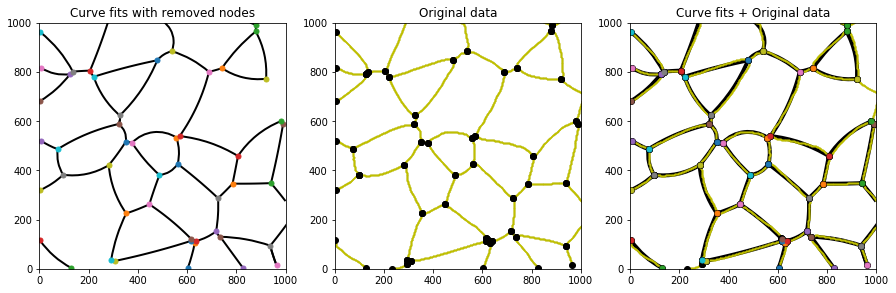

In [12]:
# check edge and node plots from class

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
fig, (ax, ax1, ax2) = plt.subplots(1,3, figsize = (15,5))

[n.plot(ax, lw = 2) for n in edges]
[n.plot(ax, markersize = 10) for n in nodes]
ax.set(xlim = [0,1000], ylim = [0,1000], aspect = 1)


for aa in [ax1,ax2]:
    for pos in posit:
        l = len(data1[2][t][pos][:])-1
        # all edges/branches
        aa.plot(data1[1][t][data1[2][t][pos][:],1], data1[1][t][data1[2][t][pos][:],0],'.',color = 'y', markersize = 1)

        # nodes (endpoints)
        aa.plot(data1[1][t][data1[2][t][pos][0],1], data1[1][t][data1[2][t][pos][0],0], 'ok')
        aa.plot(data1[1][t][data1[2][t][pos][l],1], data1[1][t][data1[2][t][pos][l],0], 'ok')
        
[n.plot(ax2, lw = 4) for n in edges]
[n.plot(ax2, markersize = 10) for n in nodes]
ax2.set(xlim = [0,1000], ylim = [0,1000], aspect = 1)
        
ax1.set(xlim = [0,1000], ylim = [0,1000], aspect = 1)
ax1.set_title('Original data')
ax.set_title('Curve fits with removed nodes')
ax2.set_title('Curve fits + Original data')
print('Number of branches is ', len(edges))
print('Number of nodes is ', len(nodes))

Next we make sure there are only triple junctions or higher -> meaning no double junctions

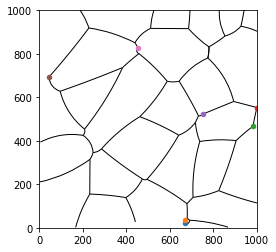

In [12]:
np.array([len(n.edges) for n in nodes]).T
#3,6,26,31,34,38,42
fig, ax = plt.subplots(1,1)
ax.set_aspect(1)
ax.set(xlim =[0,1000], ylim =[0,1000])
A = [nodes[3], nodes[6], nodes[26], nodes[31], nodes[34], nodes[38], nodes[42]]
[n.plot(ax, markersize = 9) for n in A]
[e.plot(ax) for e in edges]
plt.show()


In [13]:
# Make sure theres no double junction, only triple or higher

ind, ind_edge = [], []
new_edges = []

n1, n2 ,r = [],[],[]

for n in nodes:
    if len(n.edges) == 2:
        
        # Get the index of the node to be deleted later
        ind.append(nodes.index(n))
        print(ind)
        # Get the 2 edges associated with this node
        edge1 = n.edges[0]
        edge2 = n.edges[1]
        
        print(1)
        
        
        # Get the indices of the 2 edges to be deleted later
        
        ind_edge.append(edges.index(edge1))
        print(2)
        ind_edge.append(edges.index(edge2))
        print(3)
        
        
        # Get the non-common nodes of the 2 edges that become node_a and node_b
        node_a = edge1.nodes.difference([n]).pop()
        node_b = edge2.nodes.difference([n]).pop()

                
        # Define a new radius
        new_rad = (edge1.radius + edge2.radius)/2
        n1.append(node_a)
        n2.append(node_b)
        r.append(new_rad)
        
        # add a new edge with new nodes and new radius
#         new_edge = edge(node_a, node_b, new_rad)
#         new_edges.append(new_edge)
        
# Delete all the bad nodes
print('Before')
print('Number of branches is ', len(edges))
print('Number of nodes is ', len(nodes))

# for i in ind:
#     n = nodes[i]
#     try:
#         edge1 = n.edges[0]
#         node_a = edge1.nodes.difference([n]).pop()
#         # Delete edge1 and edge2 from the list of edges connected to node_a and node_b respectively
#         node_a.tension_vectors.pop(node_a.edges.index(edge1))
        
#         node_a.edges.remove(edge1)
#     except:
#         pass
        
#     try:
#         edge2 = n.edges[1]
#         node_b = edge2.nodes.difference([n]).pop()
#         node_b.tension_vectors.pop(node_b.edges.index(edge2))
#         node_b.edges.remove(edge2)
#     except:
#         pass


for index in sorted(ind, reverse=True):
    n = nodes[index]
    if len(n.edges) > 0:
        edge1 = n.edges[0]
        node_a = edge1.nodes.difference([n]).pop()
        # Delete edge1 and edge2 from the list of edges connected to node_a and node_b respectively
        node_a.tension_vectors.pop(node_a.edges.index(edge1))
        node_a.edges.remove(edge1)
    if len(n.edges) > 1:
        edge2 = n.edges[1]
        node_b = edge2.nodes.difference([n]).pop()
        node_b.tension_vectors.pop(node_b.edges.index(edge2))
        node_b.edges.remove(edge2)
    
    del nodes[index]
    
# Delete all the bad edges
for index in sorted(ind_edge, reverse=True):
    del edges[index]

for j in range(len(n1)):
    new_edge = edge(n1[j], n2[j], r[j])
    edges.append(new_edge)

# Add all new adges
# for e in new_edges:
#     edges.append(e)

print('After')
print('Number of branches is ', len(edges))
print('Number of nodes is ', len(nodes))
        
        

[3]
1
2
3
[3, 6]
1
2
3
[3, 6, 26]
1
2
3
[3, 6, 26, 31]
1
2
3
[3, 6, 26, 31, 34]
1
2
3
[3, 6, 26, 31, 34, 38]
1
2
3
[3, 6, 26, 31, 34, 38, 42]
1
2
3
Before
Number of branches is  65
Number of nodes is  54
After
Number of branches is  58
Number of nodes is  47


In [14]:
print(ind)

[3, 6, 26, 31, 34, 38, 42]


In [15]:
print(nodes[6].edges[i] == edges[3] for i in range(2))
edges[3]

<generator object <genexpr> at 0x132e2b0150>


Plot it again

Number of branches is  58
Number of nodes is  47


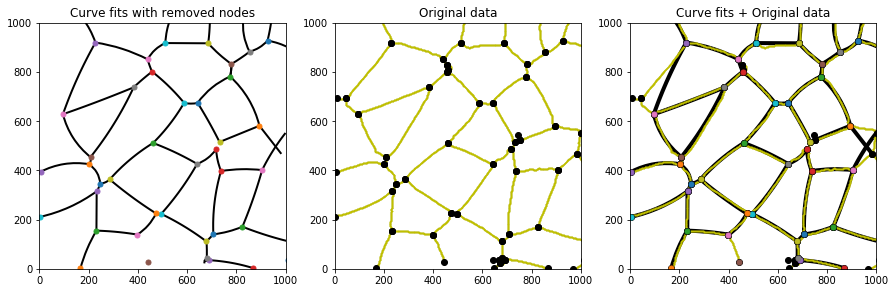

In [16]:
# check edge and node plots from class

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
fig, (ax, ax1, ax2) = plt.subplots(1,3, figsize = (15,5))

[n.plot(ax, lw = 2) for n in edges]
[n.plot(ax, markersize = 10) for n in nodes]
ax.set(xlim = [0,1000], ylim = [0,1000], aspect = 1)


for aa in [ax1,ax2]:
    for pos in posit:
        l = len(data1[2][t][pos][:])-1
        # all edges/branches
        aa.plot(data1[1][t][data1[2][t][pos][:],1], data1[1][t][data1[2][t][pos][:],0],'.',color = 'y', markersize = 1)

        # nodes (endpoints)
        aa.plot(data1[1][t][data1[2][t][pos][0],1], data1[1][t][data1[2][t][pos][0],0], 'ok')
        aa.plot(data1[1][t][data1[2][t][pos][l],1], data1[1][t][data1[2][t][pos][l],0], 'ok')
        
[n.plot(ax2, lw = 4) for n in edges]
[n.plot(ax2, markersize = 10) for n in nodes]
ax2.set(xlim = [0,1000], ylim = [0,1000], aspect = 1)
        
ax1.set(xlim = [0,1000], ylim = [0,1000], aspect = 1)
ax1.set_title('Original data')
ax.set_title('Curve fits with removed nodes')
ax2.set_title('Curve fits + Original data')
print('Number of branches is ', len(edges))
print('Number of nodes is ', len(nodes))

In [ ]:
# Zoom into problematic parts if need be

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
fig, ax = plt.subplots(1,1, figsize = (5,5))

[n.plot(ax, lw = 2) for n in edges]
[n.plot(ax, markersize = 10) for n in nodes]
ax.set(xlim = [400,600], ylim = [400,800], aspect = 1)

This feels like as much cleaning up as possible. We first removed all overlapping nodes, then removed nodes connected to single edge of very small length, then removed nodes connected to 2 edges and we are left with a set of TJ or more with approximate curve fits

CELL FINDING

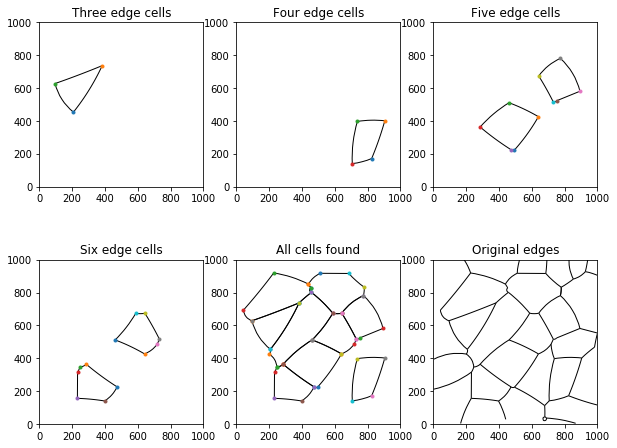

In [17]:
# Perform cell finding code. Output is cells
#type specifies direction of cell finding. 0 for minimum positive angle and 1 for maximum negative angle
# both types are implemented
# num specifies the final node (node_b if we start from node_a)
from main import main

type = 0
num = 1
cells = []

for ed in edges:
    con_edges0 = ed.connected_edges[0]
    angles1 = [ed.edge_angle(e2)  for e2 in con_edges0]
    cells = main(ed, angles1, con_edges0, cells, type, num)
    type = 1
    cells = main(ed, angles1, con_edges0, cells, type, num)
    

# plot all cells

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
fig, axes = plt.subplots(2,3,figsize=(10,8))
[cell.plot(axes[0, 0]) for cell in cells if len(cell.edges) == 3];
[cell.plot(axes[0, 1]) for cell in cells if len(cell.edges) == 4];
[cell.plot(axes[0,2]) for cell in cells if len(cell.edges) == 5];
[cell.plot(axes[1,0]) for cell in cells if len(cell.edges) == 6];
[cell.plot(axes[1,1]) for cell in cells if len(cell.edges) == 3 or 4 or 5 or 6 or 7 or 8 or 9 or 10 ];
#[cell.plot(axes[2,1]) for cell in cell_seven];
[ed.plot(axes[1,2]) for ed in edges];

[a.set(xlim=(0,1000), ylim=(0, 1000), aspect=1) for a in axes[1,:]]
[a.set(xlim=(0,1000), ylim=(0, 1000), aspect=1) for a in axes[0,:]]
#[a.set(xlim=(-1,1), ylim=(-1, 1), aspect=1) for a in axes[2,:]]
axes[1,2].set_title("Original edges")
axes[0,0].set_title("Three edge cells")
axes[0,1].set_title("Four edge cells")
axes[0,2].set_title("Five edge cells")
axes[1,0].set_title("Six edge cells")
#axes[2,1].set_title("Seven edge cells")
axes[1,1].set_title("All cells found")
plt.show()

In [18]:
# Define colony and calculate tension. Then use that to find pressure

from cell_describe import colony 

col1 = colony(cells, edges, nodes)

# A and B are the matrices. Tensions and pressures are values for each edge and cell respectively 

tensions, A, U, S, V = col1.calculate_tension()

pressures, B, rhs = col1.calculate_pressure(tensions)

Text(0.5,1,'Colony at time -> 18')

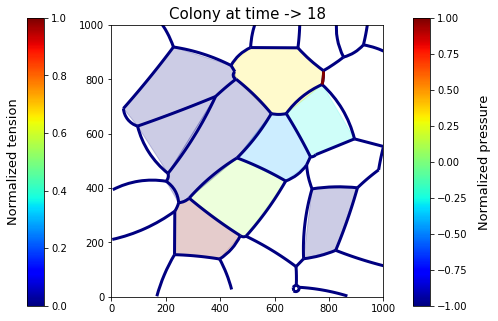

In [19]:
# plot tension and pressures on a single plot

import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
from matplotlib.colors import Normalize
import matplotlib as mpl

# Get edges from colony
edges2 = col1.tot_edges
nodes2 = col1.nodes
# edges2 = edges
# nodes2 = nodes
fig, ax = plt.subplots(1,1,figsize=(8,5))


# Normalize pressures and tensions

min_t = min(tensions)
max_t = max(tensions)

def norm(tensions):
    return (tensions - min_t) / float(max_t - min_t)
#return (tensions - np.mean(tensions))/float(np.std(tensions))

new = norm(tensions)

min_p = min(pressures)
max_p = max(pressures)

def norm(pressures):
    #return (pressures - min_p) / float(max_p - min_p)
    return (pressures - np.mean(pressures))/float(np.std(pressures))

new2 = norm(pressures)

# Plot pressures

for j, c in enumerate(cells):
    x = [n.loc[0] for n in c.nodes]
    y = [n.loc[1] for n in c.nodes]
    plt.fill(x, y, c= cm.jet(new2[j]), alpha = 0.2)

sm = plt.cm.ScalarMappable(cmap=cm.jet, norm=plt.Normalize(vmin=-1, vmax=1))
# fake up the array of the scalar mappable. 
sm._A = []

cbaxes = fig.add_axes([0.8, 0.1, 0.03, 0.8])
cl = plt.colorbar(sm, cax = cbaxes)  
cl.set_label('Normalized pressure', fontsize = 13, labelpad = 10)

# Plot tensions

for j, an_edge in enumerate(edges2):
    an_edge.plot(ax, edgecolor = cm.jet(new[j]), lw = 3)

sm = plt.cm.ScalarMappable(cmap=cm.jet, norm=plt.Normalize(vmin=0, vmax=1))
# fake up the array of the scalar mappable. 
sm._A = []

cbaxes = fig.add_axes([0.13, 0.1, 0.03, 0.8])
cl = plt.colorbar(sm, cax = cbaxes)
cl.set_label('Normalized tension', fontsize = 13, labelpad = -60)

ax.set(xlim=[0,1000], ylim=[0, 1000], aspect = 1)
ax.set_title('Colony at time -> %d' %t, fontsize = 15)

In [20]:
V.T[:,-2]

array([ 2.14332104e-01,  3.84663938e-04, -2.77555756e-17, -2.22044605e-16,
        5.51337293e-02,  7.83893254e-04,  5.79732496e-04,  9.16630737e-04,
        1.43358841e-03,  5.22401930e-04,  8.44144675e-02,  3.34509946e-02,
        3.57476067e-04, -4.67880733e-05,  1.95844479e-01,  2.59605817e-04,
        1.57015980e-04,  1.03442170e-02,  1.43420649e-02,  1.39873172e-02,
        3.50790293e-01,  4.90011825e-01,  1.26096189e-01,  4.57965960e-01,
        9.72271583e-02, -5.91118645e-05, -5.05387607e-04,  6.14724959e-05,
        5.14789801e-01,  1.44937310e-01,  2.70061773e-02,  2.44323218e-02,
        6.81860877e-02,  5.18489508e-02,  3.34301890e-05,  2.02994258e-02,
        5.21595665e-02,  1.31076461e-02,  2.00431155e-02,  9.53451759e-03,
        6.83706924e-03,  1.23709530e-02,  2.71736289e-02,  9.33097573e-03,
        3.22021841e-02,  2.88163574e-02,  2.45909608e-02,  1.58486186e-02,
        3.05696901e-02,  2.02263705e-02,  0.00000000e+00,  6.49696449e-03,
        6.45431221e-03,  